# Conv1D input layer

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd
np.random.seed(42)
tf.random.set_seed(51)

url = 'https://storage.googleapis.com/download.tensorflow.org/data/Sunspots.csv'
df = pd.read_csv(url, skiprows=0, index_col=0)   #첫 줄은 header이므로 skip 
df.shape

(3235, 2)

Data 시각화

(3235,)


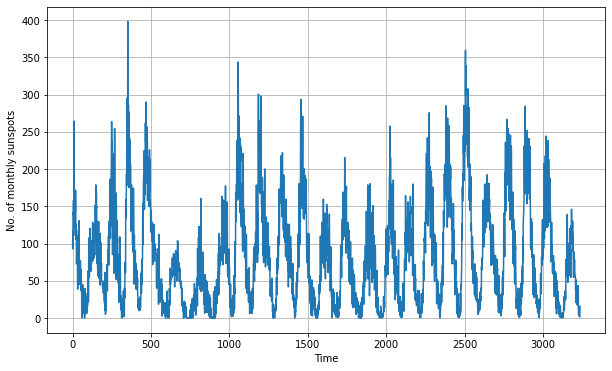

In [31]:
series = df['Monthly Mean Total Sunspot Number'].values
time = range(series.size)
print(series.shape)

plt.figure(figsize=(10, 6))
plt.plot(time, series)
plt.xlabel("Time")
plt.ylabel("No. of monthly sunspots")
plt.grid(True)

- 시간 절약을 위해 최근 500 개월치 data 만 이용

In [2]:
time = df.iloc[-500:, 0].values
time_series = df.iloc[-500:, 1].values
time.shape, time_series.shape

((500,), (500,))

### windowed dataset 생성

In [3]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer).map(lambda w: (w[:-1], w[1:]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds

### Helper Function

- training 후 series data를 model 입력 사양에 맞추기 위해 사용

In [7]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(1).prefetch(1)
    forecast = model.predict(ds)
    return forecast

### train/validation set 분리

In [5]:
split_time = 450

time_train = time[:split_time]
time_test = time[split_time:]

X_train = time_series[:split_time]
X_test  = time_series[split_time:]

len(time_train), len(time_test), len(X_train), len(X_test)

(450, 50, 450, 50)

In [6]:
window_size = 30
batch_size = 16
shuffle_buffer_size = 1000

train_ds = windowed_dataset(X_train, window_size, 
                             batch_size, shuffle_buffer_size)
train_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.float64, name=None), TensorSpec(shape=(None, None), dtype=tf.float64, name=None))>

## Conv1D + LSTM + Bidirectional

- `causal` results in causal (dilated) convolutions, e.g. 출력[t]는 입력[t + 1:]에 의존하지 않습니다.

- Causal padding 은 `Conv1D`에만 지원됩니다.

- `dilation rate`은 커널 사이의 간격을 정의. `dilation rate`가 2인 3x3 커널은 9개의 파라미터를 사용하면서 5x5 커널과 동일한 시야(view)를 가짐. 5x5 커널을 사용하고 두번째 열과 행을 모두 삭제하면 (3x3 커널을 사용한 경우 대비)동일한 계산 비용으로 더 넓은 시야를 제공. Dilated convolution은 특히 real-time segmentation 분야에서 주로 사용. 넓은 시야가 필요하고 여러 convolution이나 큰 커널을 사용할 여유가 없는 경우 사용

In [8]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1, padding="causal", 
                         activation="relu", input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 250)
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 32)          192       
                                                                 
 bidirectional (Bidirectiona  (None, None, 64)         16640     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, None, 64)         24832     
 nal)                                                            
                                                                 
 dense (Dense)               (None, None, 1)           65        
                                                                 
 lambda (Lambda)             (None, None, 1)           0         
                                                                 
Total params: 41,729
Trainable params: 41,729
Non-traina

- 초기 epoch 100 동안 learning rate를 변경해 가며 최소 mae 인 learning rate 를 찾아낸다.

In [9]:
%%time
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20)
)
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_ds, epochs=100, verbose=1, callbacks=[lr_schedule])

Epoch 1/100
27/27 [==============================] - 16s 27ms/step - loss: 110.7724 - mae: 111.2711 - lr: 1.0000e-08
Epoch 2/100
27/27 [==============================] - 0s 13ms/step - loss: 103.2478 - mae: 103.7465 - lr: 1.1220e-08
Epoch 3/100
27/27 [==============================] - 0s 13ms/step - loss: 81.8312 - mae: 82.3303 - lr: 1.2589e-08
Epoch 4/100
27/27 [==============================] - 0s 13ms/step - loss: 72.7879 - mae: 73.2862 - lr: 1.4125e-08
Epoch 5/100
27/27 [==============================] - 0s 13ms/step - loss: 71.2954 - mae: 71.7943 - lr: 1.5849e-08
Epoch 6/100
27/27 [==============================] - 0s 13ms/step - loss: 70.0290 - mae: 70.5276 - lr: 1.7783e-08
Epoch 7/100
27/27 [==============================] - 0s 14ms/step - loss: 68.7840 - mae: 69.2828 - lr: 1.9953e-08
Epoch 8/100
27/27 [==============================] - 0s 14ms/step - loss: 67.4667 - mae: 67.9655 - lr: 2.2387e-08
Epoch 9/100
27/27 [==============================] - 0s 14ms/step - loss: 66.0806 -

- 시각화를 통해 안정적 상태에서 최소 mae 를 얻은 learning rate 선택

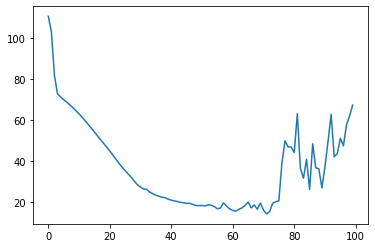

In [10]:
plt.plot(history.history["loss"])

(1e-07, 0.0001, 12.0, 30.0)

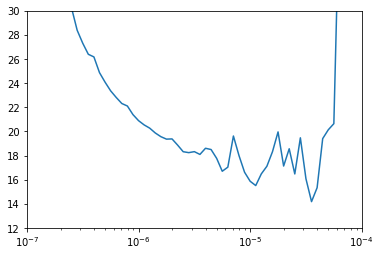

In [14]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 1e-4, 12, 30])

In [15]:
idx = list(np.array(history.history["loss"]) == np.min(history.history["loss"]))

In [16]:
best_lr = np.array(tuple(history.history['lr']))[idx]
best_lr

array([3.548134e-05], dtype=float32)

### optimal learning rate로 충분한 epoch train

- kernel size를 3으로 조정하고, Lambda layer 를 `x * 200`으로 조정

In [17]:
%%time
tf.keras.backend.clear_session()
train_set = windowed_dataset(X_train, window_size, 
                    batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=1, padding="causal", 
                         activation="relu", input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=best_lr[0], momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set, epochs=500, verbose=1)

Epoch 1/500
27/27 [==============================] - 8s 15ms/step - loss: 38.2543 - mae: 38.7504
Epoch 2/500
27/27 [==============================] - 0s 14ms/step - loss: 36.6347 - mae: 37.1310
Epoch 3/500
27/27 [==============================] - 0s 13ms/step - loss: 29.5173 - mae: 30.0126
Epoch 4/500
27/27 [==============================] - 0s 14ms/step - loss: 20.6802 - mae: 21.1738
Epoch 5/500
27/27 [==============================] - 0s 14ms/step - loss: 22.2992 - mae: 22.7932
Epoch 6/500
27/27 [==============================] - 0s 13ms/step - loss: 17.5410 - mae: 18.0333
Epoch 7/500
27/27 [==============================] - 0s 13ms/step - loss: 17.0238 - mae: 17.5153
Epoch 8/500
27/27 [==============================] - 0s 14ms/step - loss: 16.9017 - mae: 17.3941
Epoch 9/500
27/27 [==============================] - 0s 14ms/step - loss: 16.9818 - mae: 17.4741
Epoch 10/500
27/27 [==============================] - 0s 13ms/step - loss: 17.4854 - mae: 17.9785
Epoch 11/500
27/27 [=========

In [18]:
print(time_series.shape)
print(X_test.shape)

(500,)
(50,)


X_test data 를 이용하여 forecast

In [19]:
forecast = model_forecast(model, X_test, window_size)
forecast = forecast[:, -1, 0]
forecast.shape

(21,)

### True value와 prediction value 비교 시각화

X_test는 초반 window_size 만큼 skip 하고 시각화

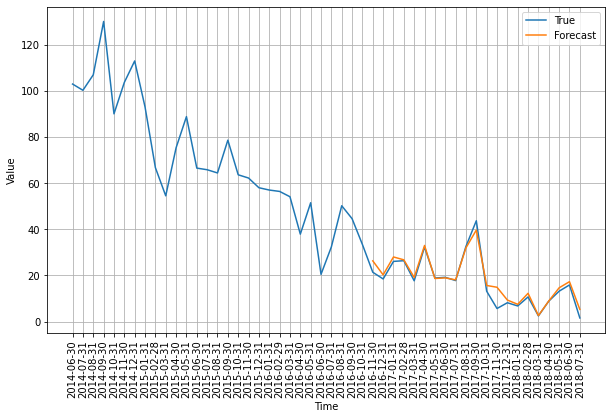

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(time_test, X_test, label='True')
plt.plot(time_test[-len(forecast):] , forecast, label='Forecast')
plt.xlabel("Time")
plt.ylabel("Value")
plt.xticks(rotation=90)
plt.grid(True)
plt.legend()

In [27]:
tf.keras.metrics.mean_absolute_error(X_test[window_size-1:], forecast).numpy()

1.8347903

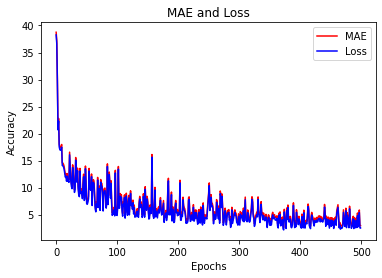

In [29]:
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])